## Library Imports

In [76]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics

# Seed for reproducibility
SEED = 13
pl.seed_everything(SEED)

Seed set to 13


13

---

## Data Load and Inspection

In [77]:
df = pd.read_parquet('data/combined_files.parquet')
print('Rows, cols:', df.shape)
display(df.head())
print('\nColumn dtypes:')
print(df.dtypes)

Rows, cols: (17490, 57)


,power,knoxville_temperature_2m,knoxville_relative_humidity_2m,knoxville_precipitation,knoxville_rain,knoxville_snowfall,knoxville_snow_depth,knoxville_apparent_temperature,knoxville_cloud_cover,knoxville_wind_speed_10m,...,month,day_percent,hour,season_Fall,season_Spring,season_Summer,season_Winter,runtime,power_1hr,power_1day
0,13510,44.399300,95.629303,0.0,0.0,0.0,0.0,39.823086,0.0,1.890231,...,1,0.064516,0,False,False,False,True,24.0,13902.0,14421.0
1,13114,45.749298,94.351883,0.0,0.0,0.0,0.0,42.451595,13.0,1.200324,...,1,0.064516,1,False,False,False,True,25.0,13510.0,13940.0
2,12887,45.299301,94.991661,0.0,0.0,0.0,0.0,42.088787,4.0,1.101308,...,1,0.064516,2,False,False,False,True,26.0,13114.0,13621.0
3,12737,44.219299,95.956245,0.0,0.0,0.0,0.0,40.415550,51.0,1.368721,...,1,0.064516,3,False,False,False,True,27.0,12887.0,13406.0
4,12834,47.369301,91.849159,0.0,0.0,0.0,0.0,43.957150,39.0,1.417247,...,1,0.064516,4,False,False,False,True,28.0,12737.0,13258.0



Column dtypes:
power                                           int64
knoxville_temperature_2m                      float32
knoxville_relative_humidity_2m                float32
knoxville_precipitation                       float32
knoxville_rain                                float32
knoxville_snowfall                            float32
knoxville_snow_depth                          float32
knoxville_apparent_temperature                float32
knoxville_cloud_cover                         float32
knoxville_wind_speed_10m                      float32
knoxville_is_day                                 bool
knoxville_sunshine_duration                   float32
knoxville_weather_code_drizzle                   bool
knoxville_weather_code_rain                      bool
knoxville_weather_code_solid precipitation       bool
nashville_temperature_2m                      float32
nashville_relative_humidity_2m                float32
nashville_precipitation                       float32
nashville_ra

---

## Quick EDA

count    17490.000000
mean     18426.669182
std       3765.538077
min      11772.000000
25%      15843.250000
50%      17513.000000
75%      20508.250000
max      34376.000000
Name: power, dtype: float64

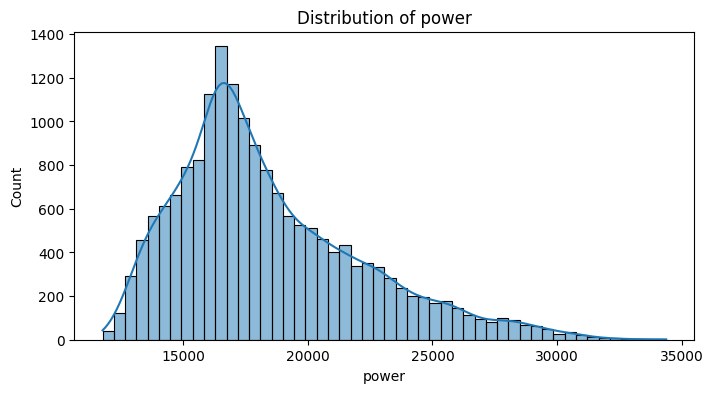

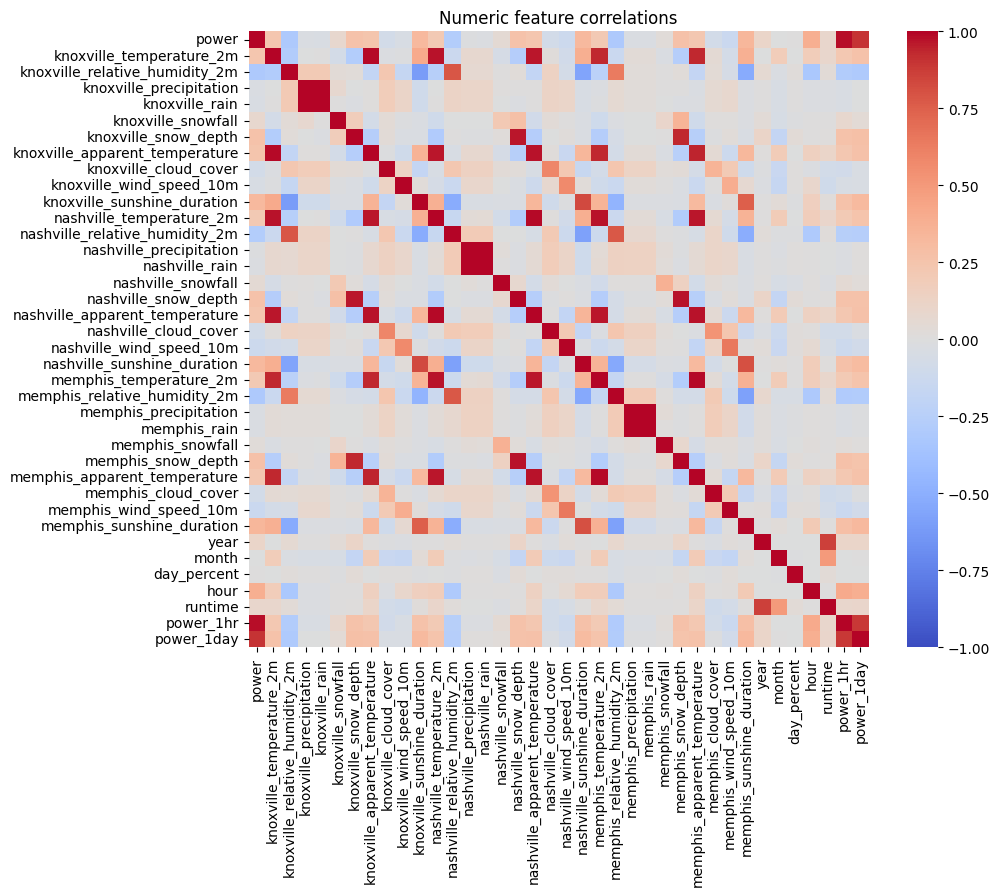

In [78]:
# Quick stats
display(df['power'].describe())

# Distribution plot
plt.figure(figsize = (8,4))
sns.histplot(df['power'].dropna(), kde = True, bins = 50)
plt.title('Distribution of power')
plt.show()

# Correlation heatmap for numeric columns
numeric = df.select_dtypes(include = [np.number])
corr = numeric.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, cmap = 'coolwarm', center = 0, vmax = 1, vmin = -1)
plt.title('Numeric feature correlations')
plt.show()

---

## Preprocessing & Feature Engineering

In [79]:
X_all = df.drop(columns = ['power'])
y_all = df['power']

# Option: apply log(1+power) to y to reduce skew - disabled by default
APPLY_LOG_TARGET = False
if APPLY_LOG_TARGET:
    y_all = np.log1p(y_all)

# Save original index mapping for reproducibility
indices = np.arange(len(X_all))

# Train/val/test split (80/10/10)
X_temp, X_test, y_temp, y_test, idx_temp, idx_test = train_test_split(
    X_all, y_all, indices, test_size=0.10, random_state=SEED, shuffle=True)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.111111111, random_state=SEED, shuffle=True)
print('train/val/test sizes:', X_train.shape[0], X_val.shape[0], X_test.shape[0])

# Fit StandardScaler on X_train and transform sets
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

train/val/test sizes: 13992 1749 1749


---

## Dataset and DataLoaders

In [80]:
from typing import Optional

class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype('float32')
        self.y = y.astype('float32').reshape(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])


class PowerDataModule(pl.LightningDataModule):
    """Simple DataModule that wraps already-prepared numpy arrays (scaled features)."""
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=128, num_workers=0):
        super().__init__()
        self.X_train = X_train
        self.y_train = np.array(y_train)
        self.X_val = X_val
        self.y_val = np.array(y_val)
        self.X_test = X_test
        self.y_test = np.array(y_test)
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: Optional[str] = None):
        self.train_ds = RegressionDataset(self.X_train, self.y_train)
        self.val_ds = RegressionDataset(self.X_val, self.y_val)
        self.test_ds = RegressionDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)


# Instantiate the DataModule
datamodule = PowerDataModule(X_train_s, y_train, X_val_s, y_val, X_test_s, y_test, batch_size=128, num_workers=0)

# Run setup so datasets are created
datamodule.setup()
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

---

## LightningModule: MLPRegressor

In [81]:
class MLPRegressor(pl.LightningModule):
    def __init__(self, in_dim, hidden_sizes=(128,64), lr=1e-3, dropout=0.1, weight_decay=0.0):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.model = nn.Sequential(*layers)
        self.criterion = nn.MSELoss()
        self.lr = lr
        self.weight_decay = weight_decay

        # metrics
        self.val_r2 = torchmetrics.R2Score()
        self.val_rmse = torchmetrics.MeanSquaredError(squared=False)
        self.val_mape = torchmetrics.MeanAbsolutePercentageError()

        self.test_r2 = torchmetrics.R2Score()
        self.test_rmse = torchmetrics.MeanSquaredError(squared=False)
        self.test_mape = torchmetrics.MeanAbsolutePercentageError()

    def forward(self, x):
        return self.model(x).squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze(-1)
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze(-1)
        preds = self(x)
        loss = self.criterion(preds, y)
        # update metrics
        self.val_r2.update(preds, y)
        self.val_rmse.update(preds, y)
        self.val_mape.update(preds, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        return {'val_loss': loss}

    def on_validation_epoch_end(self):
        r2 = self.val_r2.compute()
        rmse = self.val_rmse.compute()
        mape = self.val_mape.compute()
        self.log('val_r2', r2, prog_bar=True)
        self.log('val_rmse', rmse, prog_bar=True)
        self.log('val_mape', mape, prog_bar=True)
        self.val_r2.reset()
        self.val_rmse.reset()
        self.val_mape.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze(-1)
        preds = self(x)
        self.test_r2.update(preds, y)
        self.test_rmse.update(preds, y)
        self.test_mape.update(preds, y)
        return {'preds': preds, 'y': y}

    def on_test_epoch_end(self):
        r2 = self.test_r2.compute()
        rmse = self.test_rmse.compute()
        mape = self.test_mape.compute()
        self.log('test_r2', r2)
        self.log('test_rmse', rmse)
        self.log('test_mape', mape)
        print(f'Test R2: {r2:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}')
        self.test_r2.reset()
        self.test_rmse.reset()
        self.test_mape.reset()

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return opt

# Instantiate model
in_dim = X_train_s.shape[1]
model = MLPRegressor(in_dim=in_dim, hidden_sizes=(256,128), lr=1e-3, dropout=0.1)
print(model)

MLPRegressor(
  (model): Sequential(
    (0): Linear(in_features=56, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (criterion): MSELoss()
  (val_r2): R2Score()
  (val_rmse): MeanSquaredError()
  (val_mape): MeanAbsolutePercentageError()
  (test_r2): R2Score()
  (test_rmse): MeanSquaredError()
  (test_mape): MeanAbsolutePercentageError()
)


In [84]:
# --- Hyperparameter search with Optuna (with Lightning pruning) ---
# This cell runs a short Optuna sweep to tune lr, dropout, hidden sizes, and batch size.
# It runs a small number of short trials to keep runtime reasonable. Increase n_trials for a fuller search.

import optuna
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping as _EarlyStopping, Callback as _Callback

# set up a function to build and train a model for a single Optuna trial

def objective(trial):
    # hyperparameter search space
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    # choose number of layers and sizes from options
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_sizes = [int(trial.suggest_int(f'n_units_l{i}', 32, 512, step=32)) for i in range(n_layers)]
    batch_size = int(trial.suggest_categorical('batch_size', [64, 128, 256]))

    # build a fresh datamodule with the trial batch size
    num_workers = globals().get('NUM_WORKERS', 0)
    dm = PowerDataModule(X_train_s, y_train, X_val_s, y_val, X_test_s, y_test, batch_size=batch_size, num_workers=num_workers)
    dm.setup()

    # small model for trial
    trial_model = MLPRegressor(in_dim=in_dim, hidden_sizes=tuple(hidden_sizes), lr=lr, dropout=dropout)

    # use a temporary checkpoint callback path (use trial.number for uniqueness)
    cb_checkpoint = ModelCheckpoint(dirpath='models/optuna_tmp', filename=f'trial-{trial.number}', monitor='val_rmse', mode='min', save_top_k=1)

    # try to create a pruning callback, but only include it if it's a valid Lightning Callback
    pruning_cb = None
    try:
        maybe_pruning = PyTorchLightningPruningCallback(trial, monitor='val_rmse')
        if isinstance(maybe_pruning, _Callback):
            pruning_cb = maybe_pruning
    except Exception as e:
        # fallback: if the integration fails, continue without pruning
        pruning_cb = None

    # fallback early stopping if not defined earlier
    early_stop_local = _EarlyStopping(monitor='val_rmse', patience=3, mode='min')

    # build callbacks list safely
    callbacks_list = [cb_checkpoint, early_stop_local]
    if pruning_cb is not None:
        callbacks_list.append(pruning_cb)

    # configure Trainer for short runs
    # use CPU in the sweep to avoid GPU contention and undefined variables
    trainer_local = pl.Trainer(max_epochs=8, callbacks=callbacks_list, logger=False, accelerator='cpu', devices=1, deterministic=True)

    # fit using the datamodule
    trainer_local.fit(trial_model, datamodule=dm)

    # compute validation RMSE manually
    trial_model.eval()
    ys_val = np.array(y_val)
    preds_all = []
    for xb, _ in dm.val_dataloader():
        with torch.no_grad():
            preds_all.append(trial_model(xb).cpu().numpy().reshape(-1))
    preds_concat = np.concatenate(preds_all)

    rmse = math.sqrt(mean_squared_error(ys_val, preds_concat))

    return rmse

# run the study
study = optuna.create_study(direction='minimize')
N_TRIALS = 12  # adjust if you want a larger search
study.optimize(objective, n_trials=N_TRIALS)

print('Best trial:')
print(study.best_trial.params)

# expose best_params for downstream cells
best_params = study.best_trial.params

[I 2025-12-03 19:37:29,146] A new study created in memory with name: no-name-8dde3e64-22d8-4ef3-84d1-0fdc2db72a2e
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 20.4 K | train
1 | criterion | MSELoss                     | 0      | train
2 | val_r2    | R2Score                     | 

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 219/219 [00:00<00:00, 355.68it/s, val_r2=-13.5, val_rmse=1.4e+4, val_mape=0.761] 

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 219/219 [00:00<00:00, 353.79it/s, val_r2=-13.5, val_rmse=1.4e+4, val_mape=0.761]



[I 2025-12-03 19:37:33,904] Trial 0 finished with value: 13961.802175937031 and parameters: {'lr': 0.0005985023363933255, 'dropout': 0.3821535755615749, 'n_layers': 1, 'n_units_l0': 352, 'batch_size': 64}. Best is trial 0 with value: 13961.802175937031.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 201 K  | train
1 | criterion | MSELoss                     | 0

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 110/110 [00:00<00:00, 174.76it/s, val_r2=0.775, val_rmse=1.74e+3, val_mape=0.0776]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 110/110 [00:00<00:00, 173.49it/s, val_r2=0.775, val_rmse=1.74e+3, val_mape=0.0776]



[I 2025-12-03 19:37:38,883] Trial 1 finished with value: 1740.5498412857933 and parameters: {'lr': 0.0002030478478873263, 'dropout': 0.26296983883691705, 'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 288, 'n_units_l2': 352, 'batch_size': 128}. Best is trial 1 with value: 1740.5498412857933.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 24.1 K | train
1 | cri

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 258.00it/s, val_r2=-2.74, val_rmse=7.1e+3, val_mape=0.337] 

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 254.29it/s, val_r2=-2.74, val_rmse=7.1e+3, val_mape=0.337]



[I 2025-12-03 19:37:40,905] Trial 2 finished with value: 7095.394562672325 and parameters: {'lr': 0.004288437589395634, 'dropout': 0.27983418649807185, 'n_layers': 1, 'n_units_l0': 416, 'batch_size': 256}. Best is trial 1 with value: 1740.5498412857933.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 155 K  | train
1 | criterion | MSELoss                     | 0

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 219/219 [00:00<00:00, 301.74it/s, val_r2=0.699, val_rmse=2.01e+3, val_mape=0.090] 

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 219/219 [00:00<00:00, 300.13it/s, val_r2=0.699, val_rmse=2.01e+3, val_mape=0.090]



[I 2025-12-03 19:37:46,742] Trial 3 finished with value: 2011.2716748365945 and parameters: {'lr': 0.0003486882418638179, 'dropout': 0.3469536453403046, 'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 480, 'batch_size': 64}. Best is trial 1 with value: 1740.5498412857933.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 29.6 K | train
1 | criterion | MSELoss     

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 277.46it/s, val_r2=0.569, val_rmse=2.41e+3, val_mape=0.109] 

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 272.93it/s, val_r2=0.569, val_rmse=2.41e+3, val_mape=0.109]



[I 2025-12-03 19:37:48,487] Trial 4 finished with value: 2409.1909430346113 and parameters: {'lr': 0.002143395422379493, 'dropout': 0.01197454999823283, 'n_layers': 2, 'n_units_l0': 192, 'n_units_l1': 96, 'batch_size': 256}. Best is trial 1 with value: 1740.5498412857933.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 39.4 K | train
1 | criterion | MSELoss     

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 110/110 [00:00<00:00, 312.29it/s, val_r2=-17.3, val_rmse=1.57e+4, val_mape=0.854]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 110/110 [00:00<00:00, 309.48it/s, val_r2=-17.3, val_rmse=1.57e+4, val_mape=0.854]



[I 2025-12-03 19:37:51,248] Trial 5 finished with value: 15690.84726839185 and parameters: {'lr': 0.00019631767809517848, 'dropout': 0.28595757569947017, 'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 96, 'batch_size': 128}. Best is trial 1 with value: 1740.5498412857933.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 1.9 K  | train
1 | criterion | MSELoss    

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 175.56it/s, val_r2=-9.87, val_rmse=1.21e+4, val_mape=0.628]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 174.05it/s, val_r2=-9.87, val_rmse=1.21e+4, val_mape=0.628]



[I 2025-12-03 19:37:52,792] Trial 6 finished with value: 12095.646158845751 and parameters: {'lr': 0.008986817010315784, 'dropout': 0.45423124525643066, 'n_layers': 1, 'n_units_l0': 32, 'batch_size': 256}. Best is trial 1 with value: 1740.5498412857933.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 15.6 K | train
1 | criterion | MSELoss                     | 0

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 110/110 [00:00<00:00, 317.49it/s, val_r2=0.918, val_rmse=1.05e+3, val_mape=0.0446]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 110/110 [00:00<00:00, 314.60it/s, val_r2=0.918, val_rmse=1.05e+3, val_mape=0.0446]



[I 2025-12-03 19:37:55,620] Trial 7 finished with value: 1048.2782311962792 and parameters: {'lr': 0.007682100212795752, 'dropout': 0.3273785524233564, 'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'batch_size': 128}. Best is trial 7 with value: 1048.2782311962792.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 155 K  | train
1 | criterion | MSELoss      

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 6: 100%|██████████| 219/219 [00:00<00:00, 300.00it/s, val_r2=0.939, val_rmse=907.0, val_mape=0.0399]


[I 2025-12-03 19:38:00,994] Trial 8 finished with value: 906.9081058740185 and parameters: {'lr': 0.00892482293161859, 'dropout': 0.47316984570216164, 'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 480, 'batch_size': 64}. Best is trial 8 with value: 906.9081058740185.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 88.0 K | train
1 | criterion | MSELoss        

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 185.69it/s, val_r2=-20.9, val_rmse=1.72e+4, val_mape=0.929]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 180.58it/s, val_r2=-20.9, val_rmse=1.72e+4, val_mape=0.929]



[I 2025-12-03 19:38:03,459] Trial 9 finished with value: 17168.534008470262 and parameters: {'lr': 0.00021154070586479172, 'dropout': 0.4843023721254205, 'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 192, 'batch_size': 256}. Best is trial 8 with value: 906.9081058740185.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 308 K  | train
1 | criterion | MSELoss    

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 219/219 [00:00<00:00, 267.68it/s, val_r2=0.963, val_rmse=703.0, val_mape=0.0302]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 219/219 [00:00<00:00, 266.11it/s, val_r2=0.963, val_rmse=703.0, val_mape=0.0302]



[I 2025-12-03 19:38:10,358] Trial 10 finished with value: 702.5671676074822 and parameters: {'lr': 0.001349553475593885, 'dropout': 0.11487612798815255, 'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 512, 'n_units_l2': 32, 'batch_size': 64}. Best is trial 10 with value: 702.5671676074822.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/stivengl/DATA/DATA-6990/selfwork/models/optuna_tmp exists and is not empty.

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 308 K  | train
1 | criter

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 219/219 [00:00<00:00, 270.77it/s, val_r2=0.965, val_rmse=688.0, val_mape=0.0288]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 219/219 [00:00<00:00, 269.09it/s, val_r2=0.965, val_rmse=688.0, val_mape=0.0288]



[I 2025-12-03 19:38:16,901] Trial 11 finished with value: 688.1961702523489 and parameters: {'lr': 0.0017544107931818332, 'dropout': 0.12259403208600905, 'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 512, 'n_units_l2': 32, 'batch_size': 64}. Best is trial 11 with value: 688.1961702523489.


Best trial:
{'lr': 0.0017544107931818332, 'dropout': 0.12259403208600905, 'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 512, 'n_units_l2': 32, 'batch_size': 64}


---

## Trainer, Callbacks, and Training

In [85]:
# Final training
# Use best_params if available, otherwise use simple defaults
hidden_sizes = (256, 128)
lr = 1e-3
dropout = 0.1
batch_size = globals().get('BATCH_SIZE', 128)

if 'best_params' in globals() and isinstance(best_params, dict):
    bp = best_params
    n_layers = int(bp.get('n_layers', 2))
    hidden_sizes = tuple(int(bp.get(f'n_units_l{i}', 128)) for i in range(n_layers))
    lr = float(bp.get('lr', lr))
    dropout = float(bp.get('dropout', dropout))
    batch_size = int(bp.get('batch_size', batch_size))

print(f"Training with hidden_sizes={hidden_sizes}, lr={lr}, dropout={dropout}, batch_size={batch_size}")

# Recreate datamodule for training
num_workers = globals().get('NUM_WORKERS', 0)
datamodule = PowerDataModule(X_train_s, y_train, X_val_s, y_val, X_test_s, y_test, batch_size=batch_size, num_workers=num_workers)
datamodule.setup()

EPOCHS = 20
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='auto')

# Build and train model
model = MLPRegressor(in_dim=in_dim, hidden_sizes=hidden_sizes, lr=lr, dropout=dropout)
trainer.fit(model, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Training with hidden_sizes=(512, 512, 32), lr=0.0017544107931818332, dropout=0.12259403208600905, batch_size=64


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | Sequential                  | 308 K  | train
1 | criterion | MSELoss                     | 0      | train
2 | val_r2    | R2Score                     | 0      | train
3 | val_rmse  | MeanSquaredError            | 0      | train
4 | val_mape  | MeanAbsolutePercentageError | 0      | train
5 | test_r2   | R2Score                     | 0      | train
6 | test_rmse | MeanSquaredError            | 0      | train
7 | test_mape | MeanAbsolutePercentageError | 0      | train
------------------------------------------------------------------
308 K     Trainable params
0         Non-trainable params
308 K     Total params
1.233     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode

  

/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stivengl/DATA/DATA-6990/selfwork/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 219/219 [00:01<00:00, 116.30it/s, v_num=3, val_r2=0.978, val_rmse=541.0, val_mape=0.023]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 219/219 [00:01<00:00, 115.69it/s, v_num=3, val_r2=0.978, val_rmse=541.0, val_mape=0.023]



## Evaluate on test set

In [86]:
# Test evaluation
model.eval()
xs = torch.from_numpy(X_test_s.astype('float32'))
with torch.no_grad():
    preds = model(xs).cpu().numpy().reshape(-1)
ys = np.array(y_test)
print('Sanity check:')
print('R2:', round(r2_score(ys, preds), 4))
print('RMSE:', round(math.sqrt(mean_squared_error(ys, preds)), 4))
print('MAPE:', round(mean_absolute_percentage_error(ys, preds), 6))

Sanity check:
R2: 0.9788
RMSE: 541.8466
MAPE: 0.022206


---

## Example inference

In [87]:
# Example inference
example_row = X_test_s[0:1]  # already scaled
example_tensor = torch.from_numpy(example_row.astype('float32'))
model.eval()
with torch.no_grad():
    pred = model(example_tensor).cpu().numpy().reshape(-1)[0]
truth = y_test.iloc[0] if hasattr(y_test, 'iloc') else y_test[0]
print(f'Example prediction: {pred:.4f}; Ground truth: {truth:.4f}')

Example prediction: 16328.9092; Ground truth: 16453.0000


---

## Residuals and Predictions visualization

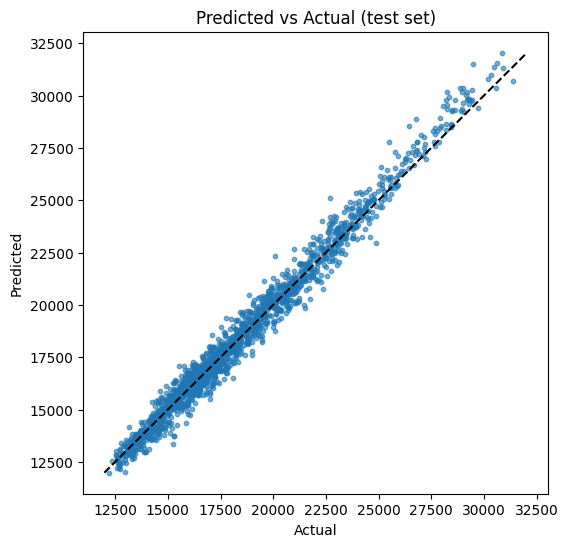

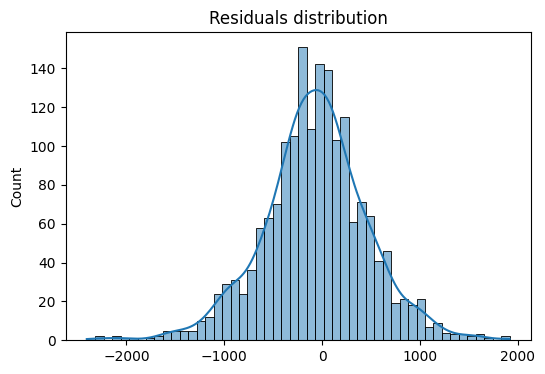

In [88]:
# Produce predictions for whole test set
model.eval()
with torch.no_grad():
    preds_all = model(torch.from_numpy(X_test_s.astype('float32'))).cpu().numpy().reshape(-1)
ys_all = np.array(y_test)

plt.figure(figsize=(6,6))
plt.scatter(ys_all, preds_all, alpha=0.6, s=10)
lims = [min(ys_all.min(), preds_all.min()), max(ys_all.max(), preds_all.max())]
plt.plot(lims, lims, '--k')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual (test set)')
plt.show()

residuals = ys_all - preds_all
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residuals distribution')
plt.show()